In [1]:
from astropy.nddata import NDDataArray as nda, StdDevUncertainty as sdu
from astropy.table import Table, column
import astropy.units as u
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [48]:
morph_data = Table.read('fits/morph_data.fits')
structure_data = Table.read('fits/structure_data.fits')
hi_data = Table.read('fits/hi_data.fits')

masks = Table.read('fits/masks.fits')
halo_data = Table.read('fits/halo_table_all.fits')

gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [152]:
halo_data['M_baryonic'] = halo_data['M_disc_total'] + halo_data['M_bulge']
halo_data['bulge_frac'] = halo_data['M_bulge'] / halo_data['M_baryonic']
halo_data['disc_frac'] = halo_data['M_disc_total'] / halo_data['M_baryonic']
halo_data['halo_frac'] = halo_data['M_halo'] / halo_data['M_baryonic']

halo_data['M_total_2.2'] = (halo_data['M_disc_total_2.2']
                          + halo_data['M_bulge_2.2']
                          + halo_data['M_halo_2.2'])

halo_data['bulge_frac_2.2'] = halo_data['M_bulge_2.2']/halo_data['M_total_2.2']
halo_data['disc_frac_2.2'] = halo_data['M_disc_total_2.2']/halo_data['M_total_2.2']
halo_data['halo_frac_2.2'] = halo_data['M_halo_2.2']/halo_data['M_total_2.2']


5.0th percentile = 0.0
10.0th percentile = 0.0020000000949949026
15.0th percentile = 0.014000000432133675
20.0th percentile = 0.0430000014603138
25.0th percentile = 0.0860000029206276
30.0th percentile = 0.13600000739097595
35.0th percentile = 0.1889999955892563
40.0th percentile = 0.24199999868869781
45.0th percentile = 0.2919999957084656
50.0th percentile = 0.3370000123977661
55.0th percentile = 0.37700000405311584
60.0th percentile = 0.41200000047683716
65.0th percentile = 0.4429999887943268
70.0th percentile = 0.4699999988079071
75.0th percentile = 0.49300000071525574
80.0th percentile = 0.5149999856948853
85.0th percentile = 0.5550000071525574
90.0th percentile = 0.6349999904632568
95.0th percentile = 0.7879999876022339


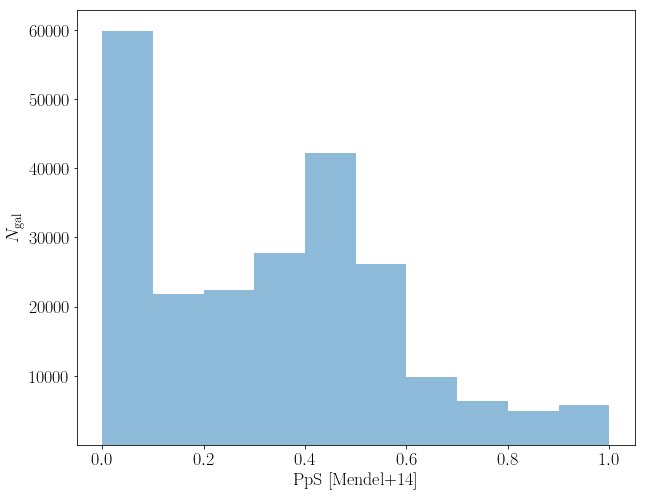

In [193]:
has_mendel = structure_data['ok']
_ = plt.hist(structure_data['PpS_mendel'][has_mendel],alpha=0.5)

for p in np.linspace(5,95,19):
    percentile = np.percentile(structure_data['PpS_mendel'][has_mendel],p)
    print('{}th percentile = {}'.format(p,percentile))
    
_ = plt.xlabel('PpS [Mendel+14]')
_ = plt.ylabel('$N_\mathrm{gal}$')

In [201]:
# --- sample selection:

redshift_ok = masks['in_redshift']
redshift_ok = np.all([morph_data['redshift'] >= 0.01,
                      morph_data['redshift'] <= 0.085],axis=0)
hi_ok = masks['hi_ok']

# Check the structure:
disc_ok = structure_data['PpS_mendel'] <= 0.32 # Mendel+ 2-component system
axial_ok = morph_data['axial_ratio'] >= 0.4 # Hart+17, Masters+10
fit_ok = structure_data['ok']
mass_ok = masks['mass_ok']

star_forming = masks['star_forming']

sample_ok = np.all([redshift_ok,hi_ok,mass_ok,fit_ok,
                    disc_ok,axial_ok],axis=0)
sf_sample = np.all([sample_ok,star_forming],axis=0)
non_sf_sample = np.all([sample_ok,star_forming == False],axis=0)

print('{} discs in the final sample'.format(sample_ok.sum()))
print('{} are SF'.format(sf_sample.sum()))
print('{} are none-SF'.format(non_sf_sample.sum()))

54795 discs in the final sample
27213 are SF
27582 are none-SF


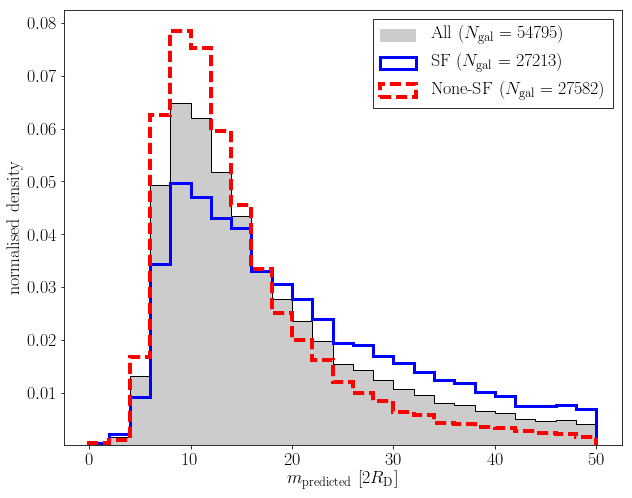

In [202]:
fig = plt.figure()
ax = plt.subplot(111)

bins = np.linspace(0,50,26)
    
_ = ax.hist(halo_data['m_predicted_2R_d'][sample_ok],bins,normed=True,
            histtype='stepfilled',color='k',alpha=0.2,
            label='All ($N_\mathrm{{gal}}={}$)'.format(sample_ok.sum()))

_ = ax.hist(halo_data['m_predicted_2R_d'][sample_ok],bins,normed=True,
            histtype='step',color='k',lw=1,label='_nolegend_')

_ = ax.hist(halo_data['m_predicted_2R_d'][sf_sample],bins,normed=True,
            histtype='step',color='b',lw=3,
            label='SF ($N_\mathrm{{gal}}={}$)'.format(sf_sample.sum()))

_ = ax.hist(halo_data['m_predicted_2R_d'][non_sf_sample],bins,normed=True,
            histtype='step',color='r',lw=4,linestyle='dashed',
            label='None-SF ($N_\mathrm{{gal}}={}$)'.format(non_sf_sample.sum()))

_ = ax.set_xlabel('$m_\mathrm{predicted}$ [$2R_\mathrm{D}$]')
_ = ax.set_ylabel('normalised density')
_ = ax.legend(fancybox=False,edgecolor='k')

In [203]:
### --- Re-mask the data ---

p_spiral_ok = np.isfinite(morph_data['p_spiral'])
arms_ok = np.all([halo_data['m_predicted_2R_d'] >= 0,
                  halo_data['m_predicted_2R_d'] <= 50],axis=0)

low_z = morph_data['redshift'] <= 0.04

def remask(mask):
    return np.all([mask,p_spiral_ok,arms_ok],axis=0)

def low_z_mask(mask):
    return np.all([mask,low_z],axis=0)

sample_ok = remask(sample_ok)
sf_sample = remask(sf_sample)
non_sf_sample = remask(non_sf_sample)

sample_ok_low_z = low_z_mask(sample_ok)
sf_sample_low_z = low_z_mask(sf_sample)
non_sf_sample_low_z = low_z_mask(non_sf_sample)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in log10


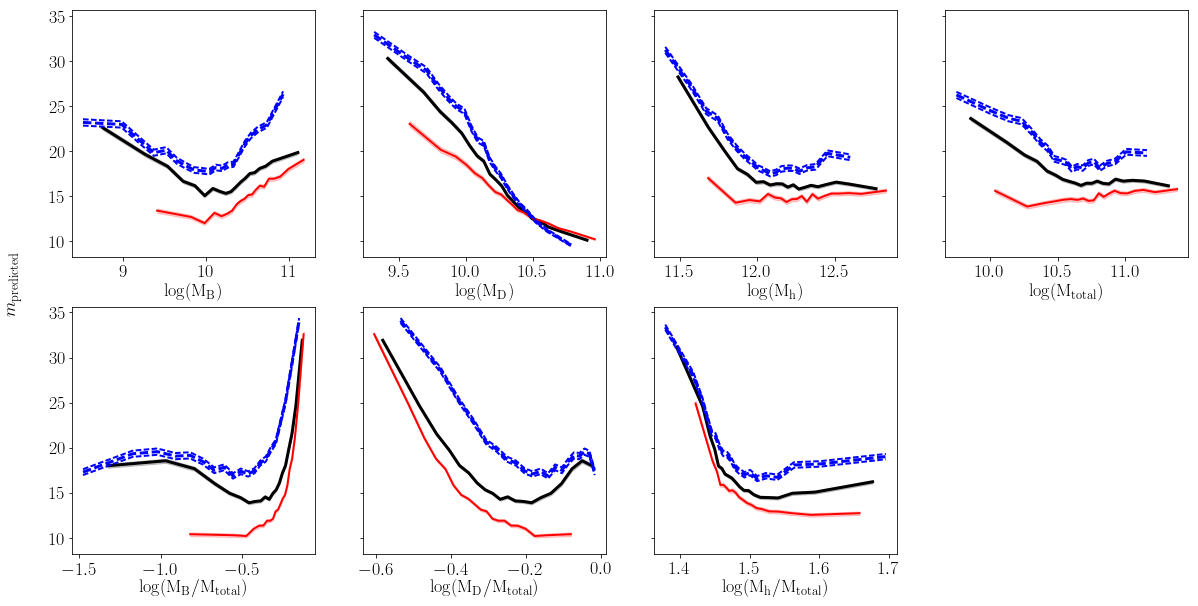

In [204]:
from xy_plots import x_vs_y

fig, axarr = plt.subplots(2,4,figsize=(20,10),sharey=True)
axarr = axarr.ravel()
fig.delaxes(axarr[-1])

y = halo_data['m_predicted_2R_d']
x_columns = ['M_bulge','M_disc_stars','M_halo','M_baryonic',
             'bulge_frac','disc_frac','halo_frac']
xs = [np.log10(halo_data[c]) for c in x_columns]
xlabels = ['$\log(\mathrm{M_B})$','$\log(\mathrm{M_D})$',
           '$\log(\mathrm{M_h})$','$\log(\mathrm{M_{total}})$',
           '$\log(\mathrm{M_B/M_{total}})$','$\log(\mathrm{M_D/M_{total}})$',
           '$\log(\mathrm{M_h/M_{total}})$']

colors = 'rbkyrbk'

for x, xlabel, ax, color in zip(xs,xlabels,axarr,colors):
    
    xy = x_vs_y(x[sample_ok],y[sample_ok])
    xy.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy.line_plot(ax,color='k',lw=3,linestyle='solid')
    xy.error_plot(ax,color='k',style='filled',
                  alpha=0.2)
    
    xy_nsf = x_vs_y(x[non_sf_sample],y[non_sf_sample])
    xy_nsf.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy_nsf.line_plot(ax,color='r',lw=2)
    xy_nsf.error_plot(ax,color='r',alpha=0.2)
    
    xy_sf = x_vs_y(x[sf_sample],y[sf_sample])
    xy_sf.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy_sf.line_plot(ax,color='b',lw=3,linestyle='dashed')
    xy_sf.error_plot(ax,color='b',style='lined',lw=2,linestyle='dashed')
    
    ax.set_xlabel(xlabel)
    
_ = fig.text(0.08, 0.5, '$m_\mathrm{predicted}$', va='center', rotation='vertical')

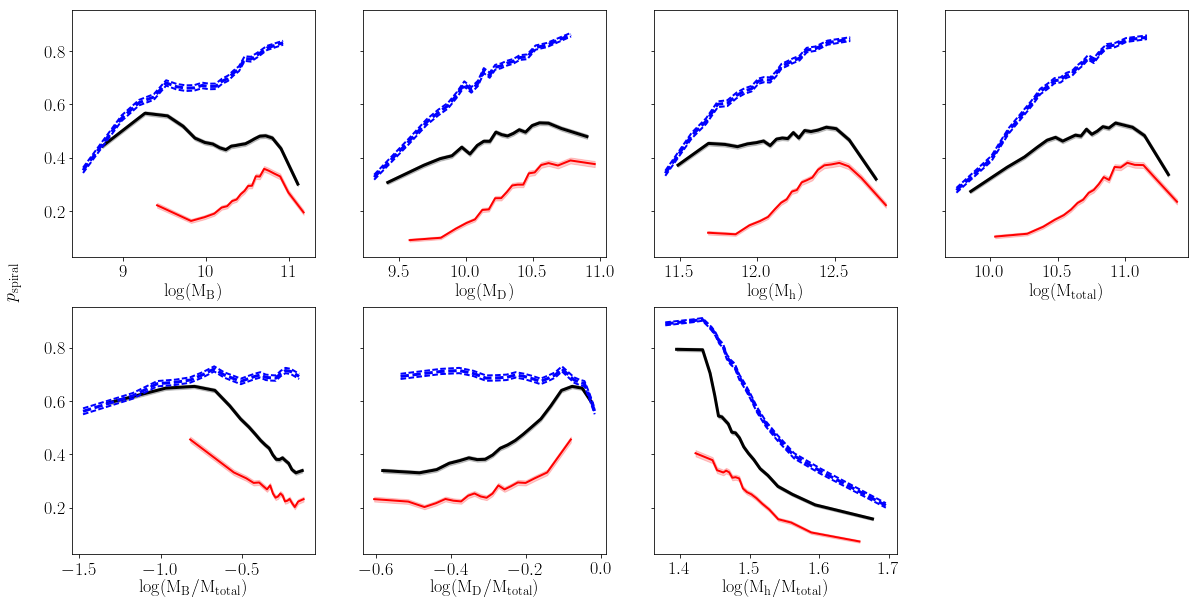

In [205]:
#### Now: is there a notable drop off in p_spiral at that mass?
fig, axarr = plt.subplots(2,4,figsize=(20,10),sharey=True)
axarr = axarr.ravel()
fig.delaxes(axarr[-1])

y = morph_data['p_spiral']

for x, xlabel, ax, color in zip(xs,xlabels,axarr,colors):
    
    xy = x_vs_y(x[sample_ok],y[sample_ok])
    xy.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy.line_plot(ax,color='k',lw=3,linestyle='solid')
    xy.error_plot(ax,color='k',style='filled',
                  alpha=0.2)
    
    xy_nsf = x_vs_y(x[non_sf_sample],y[non_sf_sample])
    xy_nsf.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy_nsf.line_plot(ax,color='r',lw=2)
    xy_nsf.error_plot(ax,color='r',alpha=0.2)
    
    xy_sf = x_vs_y(x[sf_sample],y[sf_sample])
    xy_sf.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy_sf.line_plot(ax,color='b',lw=3,linestyle='dashed')
    xy_sf.error_plot(ax,color='b',style='lined',lw=2,linestyle='dashed')
    
    ax.set_xlabel(xlabel)
    
_ = fig.text(0.08, 0.5, '$p_\mathrm{spiral}$', va='center', rotation='vertical')

#### Now make equivalent plots at 2.2R_d?

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


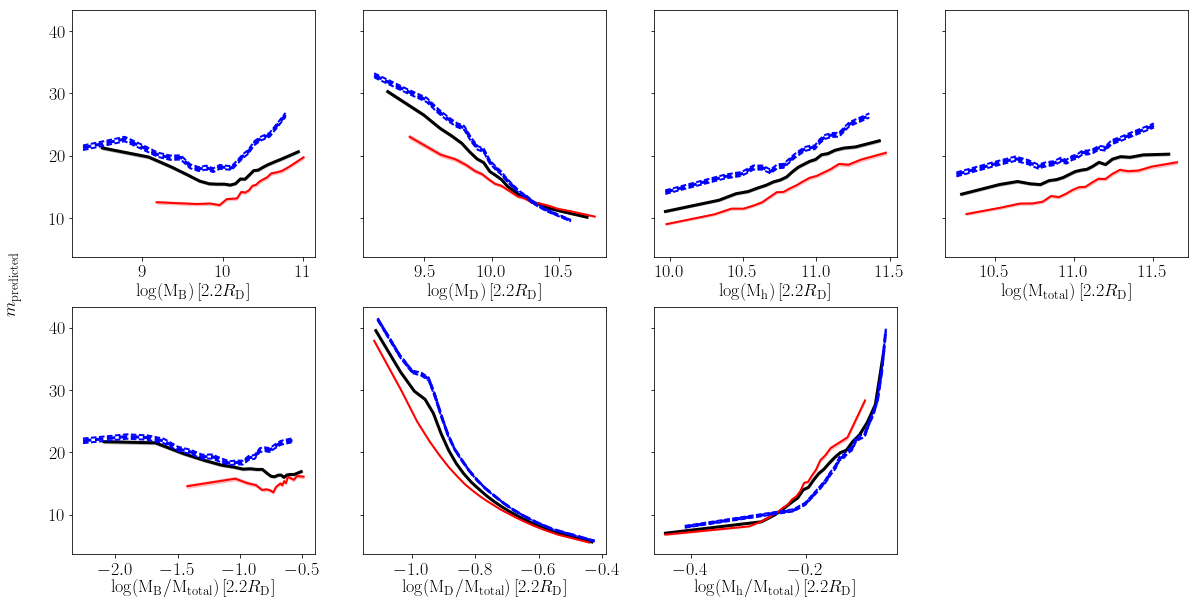

In [206]:
fig, axarr = plt.subplots(2,4,figsize=(20,10),sharey=True)
axarr = axarr.ravel()
fig.delaxes(axarr[-1])

y = halo_data['m_predicted_2R_d']
x_columns = ['M_bulge_2.2','M_disc_stars_2.2','M_halo_2.2','M_total_2.2',
             'bulge_frac_2.2','disc_frac_2.2','halo_frac_2.2']
xs = [np.log10(halo_data[c]) for c in x_columns]
xlabels = ['$\log(\mathrm{M_B}) \, [2.2R_\mathrm{D}]$',
           '$\log(\mathrm{M_D}) \, [2.2R_\mathrm{D}]$',
           '$\log(\mathrm{M_h}) \, [2.2R_\mathrm{D}]$',
           '$\log(\mathrm{M_{total}}) \, [2.2R_\mathrm{D}]$',
           '$\log(\mathrm{M_B/M_{total}}) \, [2.2R_\mathrm{D}]$',
           '$\log(\mathrm{M_D/M_{total}}) \, [2.2R_\mathrm{D}]$',
           '$\log(\mathrm{M_h/M_{total}}) \, [2.2R_\mathrm{D}]$']

colors = 'rbkyrbk'

for x, xlabel, ax, color in zip(xs,xlabels,axarr,colors):
    
    xy = x_vs_y(x[sample_ok],y[sample_ok])
    xy.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy.line_plot(ax,color='k',lw=3,linestyle='solid')
    xy.error_plot(ax,color='k',style='filled',
                  alpha=0.2)
    
    xy_nsf = x_vs_y(x[non_sf_sample],y[non_sf_sample])
    xy_nsf.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy_nsf.line_plot(ax,color='r',lw=2)
    xy_nsf.error_plot(ax,color='r',alpha=0.2)
    
    xy_sf = x_vs_y(x[sf_sample],y[sf_sample])
    xy_sf.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy_sf.line_plot(ax,color='b',lw=3,linestyle='dashed')
    xy_sf.error_plot(ax,color='b',style='lined',lw=2,linestyle='dashed')
    
    ax.set_xlabel(xlabel)
    
_ = fig.text(0.08, 0.5, '$m_\mathrm{predicted}$', va='center', rotation='vertical')

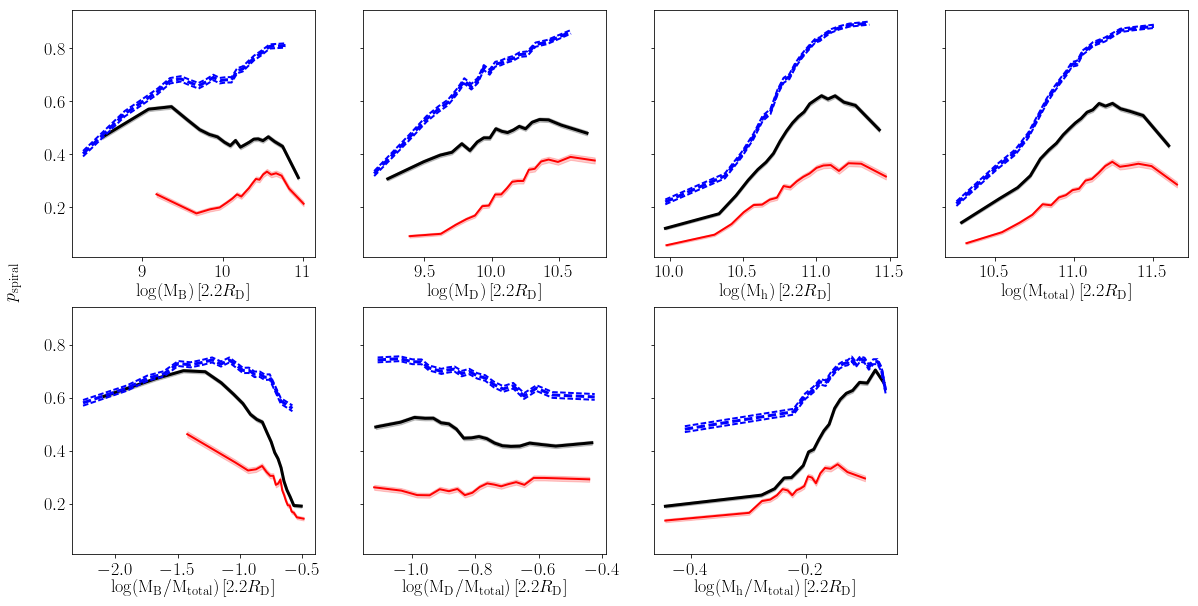

In [207]:
#### Now: is there a notable drop off in p_spiral at that mass?
fig, axarr = plt.subplots(2,4,figsize=(20,10),sharey=True)
axarr = axarr.ravel()
fig.delaxes(axarr[-1])

y = morph_data['p_spiral']

for x, xlabel, ax, color in zip(xs,xlabels,axarr,colors):
    
    xy = x_vs_y(x[sample_ok],y[sample_ok])
    xy.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy.line_plot(ax,color='k',lw=3,linestyle='solid')
    xy.error_plot(ax,color='k',style='filled',
                  alpha=0.2)
    
    xy_nsf = x_vs_y(x[non_sf_sample],y[non_sf_sample])
    xy_nsf.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy_nsf.line_plot(ax,color='r',lw=2)
    xy_nsf.error_plot(ax,color='r',alpha=0.2)
    
    xy_sf = x_vs_y(x[sf_sample],y[sf_sample])
    xy_sf.continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
    xy_sf.line_plot(ax,color='b',lw=3,linestyle='dashed')
    xy_sf.error_plot(ax,color='b',style='lined',lw=2,linestyle='dashed')
    
    ax.set_xlabel(xlabel)
    
_ = fig.text(0.08, 0.5, '$p_\mathrm{spiral}$', va='center', rotation='vertical')

#### What have we learned here?

We see that galaxies with more massive discs are predicted to have fewer spiral arms. We also see that the Galaxy Zoo $p_\mathrm{spiral}$ statistic follows a similar trend: at high spiral arm numbers, more galaxies are classified as smooth.

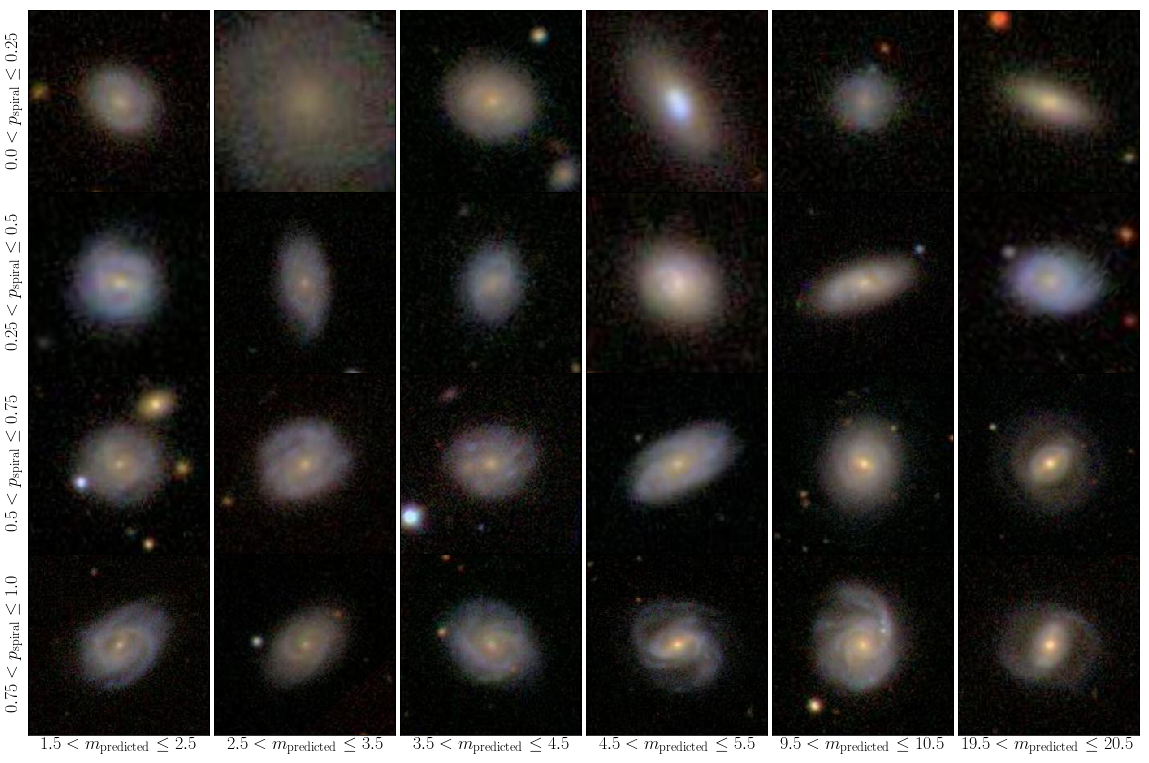

In [16]:
from display_image import display_image

np.random.seed(2)

subsample_data = gz2_data[sf_sample_low_z]
subsample_p = morph_data['p_spiral'][sf_sample_low_z]
subsample_m = halo_data['m_predicted_2R_d'][sf_sample_low_z]

p_bins = np.linspace(0,1,5)
m_vals = (2,3,4,5,10,20)

N_m = len(m_vals)
N_p = len(p_bins) - 1

fig, axarr = plt.subplots(N_p,N_m,
                          figsize=(20,N_p/N_m*20))

fig.subplots_adjust(wspace=0,hspace=0)

for p in range(N_p):
    for m in range(N_m):
        in_p = np.all([subsample_p > p_bins[p],
                       subsample_p <= p_bins[p+1]],axis=0)
        
        in_m = np.all([subsample_m > m_vals[m]-0.5,
                       subsample_m <= m_vals[m]+0.5],axis=0)
        
        plt.sca(axarr[p,m])
        galaxy_row = np.random.choice(subsample_data[(in_p) & (in_m)])
        url = galaxy_row['jpeg_url']
        _ = display_image(url)

for a, ax in enumerate(axarr[:,0]):
    ax.set_ylabel('${} < p_\mathrm{{spiral}} \leq {}$'.format(p_bins[a],p_bins[a+1]))
    
for a, ax in enumerate(axarr[-1,:]):
    ax.set_xlabel('${} < m_\mathrm{{predicted}} \leq {}$'.format(m_vals[a]-0.5,
                                                                 m_vals[a]+0.5))

#### Case study: two arm spirals?

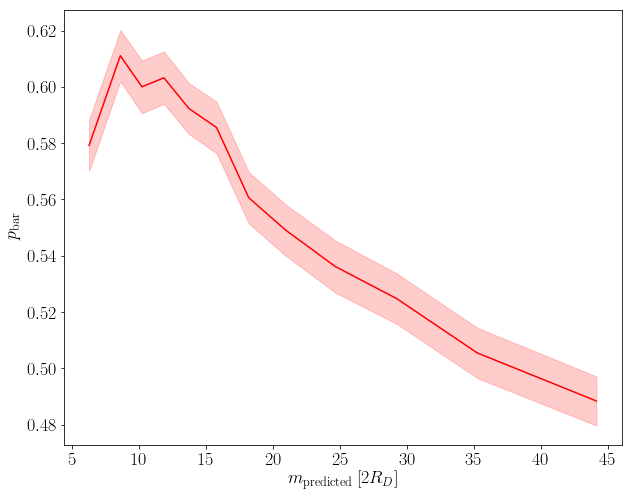

In [189]:
fig = plt.figure()
ax = plt.subplot(111)

x = halo_data['m_predicted_2R_d'][two_arm_sample]
y = morph_data['p_bar'][two_arm_sample]
xy = x_vs_y(x,y).continuous_vs_continuous_binned_mean(bins=12,equal_N=True)
xy.line_plot(ax,color='r')
xy.error_plot(ax,color='r',alpha=0.2)

_ = ax.set_xlabel('$m_\mathrm{predicted} \, [2R_D]$')
_ = ax.set_ylabel('$p_\mathrm{bar}$')

#### What can sparcfire give us?

In [181]:
sparcfire_data = Table.read('../sparcfire2/fits/galaxy_level_all.fits')
sparcfire_arcs = Table.read('../sparcfire2/fits/arc_table_all.fits')

In [182]:
in_spiral = np.all([morph_data['p_spiral'] > 0.5,
                    morph_data['N_spiral'] >= 5],axis=0)

unbarred = morph_data['p_bar'] <= 0.2

m_2 = np.all([morph_data['m'] == 2,in_spiral],axis=0)
m_2_sample = np.all([m_2,sample_ok,unbarred],axis=0)

N_arcs = sparcfire_data['N_arcs'] 
multi_arcs = N_arcs > 1
m_2_ids = gz2_data['dr8objid'][(m_2_sample) & (multi_arcs)]

delta_theta_list = []

for id_ in m_2_ids:
    delta_theta_list.append(theta_difference(sparcfire_arcs,id_)[0])
    
delta_thetas = np.array(delta_theta_list)
delta_thetas[np.isfinite(delta_thetas) == False] = -999

arm_symmetry = np.abs(delta_thetas - 180)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in double_scalars
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars


In [183]:
def theta_at_r(arc_row,r):
    r_i = arc_row['math_initial_radius']
    psi = arc_row['pitch_angle']*(2*math.pi/360)
    theta_i = arc_row['math_initial_theta']
    r0 = r_i/np.exp(-psi*theta_i)
    theta_r = -np.log(r/r0)/psi
    return theta_r

def theta_difference(arcs,id_):
    id_rows = arcs['gxyName'] == id_
    id_arcs = arcs[id_rows]
    
    arc_0 = id_arcs[0]
    r_centre = arc_0['r_end'] - arc_0['r_start']
    theta_0 = theta_at_r(arc_0,r_centre)
    delta_thetas = []
    for arc_n in id_arcs[1:]:
        theta_n = theta_at_r(arc_n,r_centre)
        delta_theta = (theta_n - theta_0)*(360/(2*math.pi))
        N360 = np.floor(delta_theta/360)
        delta_thetas.append(delta_theta - N360*360)
    return delta_thetas

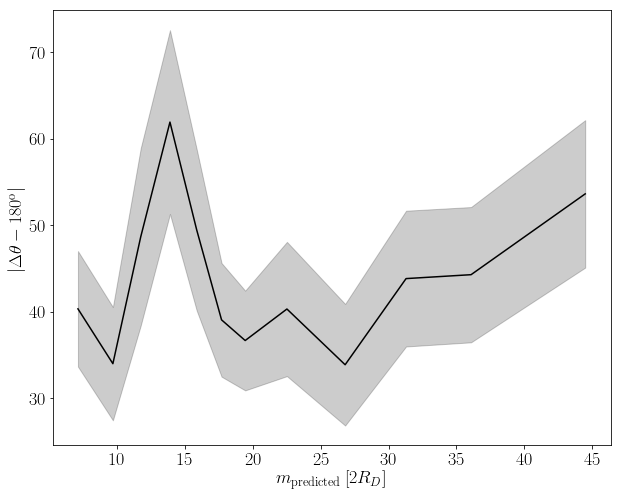

In [188]:
fig = plt.figure()
ax = plt.subplot(111)

mask = np.all([arm_symmetry > 0,arm_symmetry < 180],axis=0) 
x = halo_data['m_predicted_2R_d'][(m_2_sample) & (multi_arcs)][mask]
y = arm_symmetry[mask]
xy = x_vs_y(x,y).continuous_vs_continuous_binned_mean(bins=12,
                                                        equal_N=True)
xy.line_plot(ax,color='k')
xy.error_plot(ax,alpha=0.2,color='k')

_ = ax.set_xlabel('$m_\mathrm{predicted} \, [2R_D]$')
_ = ax.set_ylabel(r'$|\Delta \theta - 180^{\mathrm{o}}|$')

#### Is there anything in image depth?

- What I'm specifically looking at here is the effect we see with p_spiral: are the more flocculent spirals picked up by deeper images?

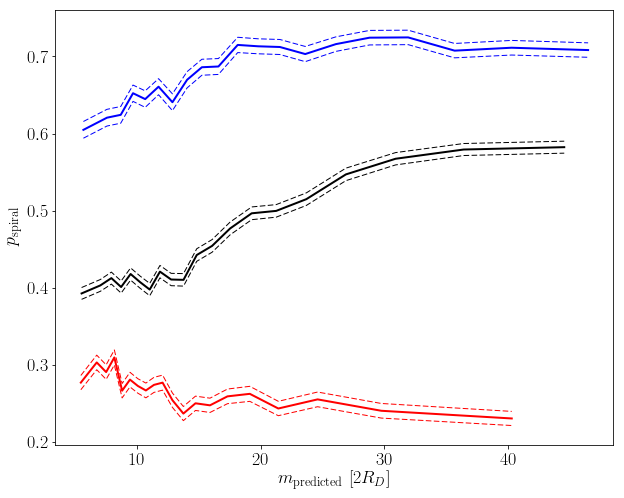

In [238]:
x = halo_data['m_predicted_2R_d']
y = morph_data['p_spiral']

xy = x_vs_y(x[sample_ok],y[sample_ok]).continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
xy_sf = x_vs_y(x[sf_sample],y[sf_sample]).continuous_vs_continuous_binned_mean(bins=20,equal_N=True)
xy_nsf = x_vs_y(x[non_sf_sample],y[non_sf_sample]).continuous_vs_continuous_binned_mean(bins=20,equal_N=True)

fig = plt.figure()
ax = plt.subplot(111)

xy.line_plot(ax,color='k',lw=2)
xy.error_plot(ax,style='lined',color='k',lw=1,linestyle='--')
xy_sf.line_plot(ax,color='b',lw=2)
xy_sf.error_plot(ax,style='lined',color='b',lw=1,linestyle='--')
xy_nsf.line_plot(ax,color='r',lw=2)
xy_nsf.error_plot(ax,style='lined',color='r',lw=1,linestyle='--')

_ = ax.set_xlabel('$m_\mathrm{predicted}$ [$2R_D$]')
_ = ax.set_ylabel('$p_\mathrm{spiral}$')

In [226]:
from combining_catalogues import match_sky_restricted, make_matched_catalogue

#gama_galaxies = Table.read('../fits/GAMA/gama_09_debiased.fits')

ids_ = match_sky_restricted(gz2_data,gama_galaxies,2,0.01,
                            ('ra_1','dec_1','REDSHIFT_1'),
                            ('RA','DEC','Z_TONRY'))

print('Only 792 matches between GAMA and Sloan?')

gama_matched = make_matched_catalogue(gz2_data,gama_galaxies,ids_)
gama_matched['dr7objid'] = gz2_data['dr7objid']

in_gama = gama_matched['mask']
gama_sample = np.all([sample_ok,in_gama],axis=0)

248883 galaxies in the reference catalogue
11285 galaxies in the match catalogue
---> 11285 matches in total
---> 792 unique matches of < 2 arcsec
---> 792 unique matches of delta-z < 0.01
Only 792 matches between GAMA and Sloan?


In [232]:
p_spiral_raw = (gz2_data['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
              * gz2_data['t02_edgeon_a05_no_weighted_fraction']
              * gz2_data['t04_spiral_a08_spiral_weighted_fraction'])

p_spiral_raw_gama = (gama_matched['shape_features_fraction']
                   * gama_matched['disk_no_fraction']
                   * gama_matched['spiral_a_spiral_fraction'])

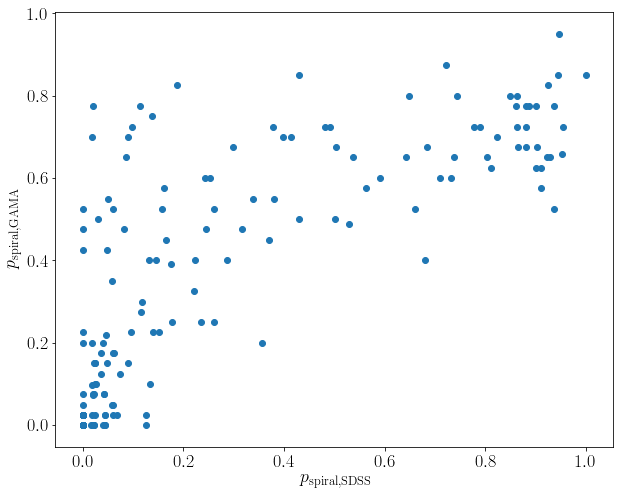

In [236]:
plt.scatter(p_spiral_raw[gama_sample],p_spiral_raw_gama[gama_sample])

_ = plt.xlabel('$p_\mathrm{spiral,SDSS}$')
_ = plt.ylabel('$p_\mathrm{spiral,GAMA}$')

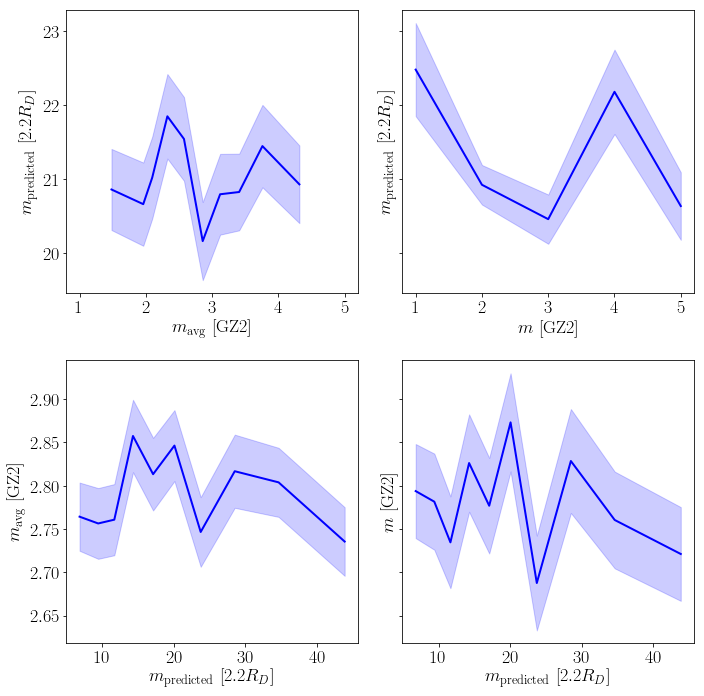

In [251]:
mask = np.all([in_spiral,unbarred,sample_ok],axis=0)

xs = [morph_data['m_avg'][mask],
      morph_data['m'][mask],
      halo_data['m_predicted_2R_d'][mask],
      halo_data['m_predicted_2R_d'][mask]]

ys = [halo_data['m_predicted_2R_d'][mask],
      halo_data['m_predicted_2R_d'][mask],
      morph_data['m_avg'][mask],
      morph_data['m'][mask]]

xlabels = ('$m_\mathrm{avg}$ [GZ2]','$m$ [GZ2]',
           '$m_\mathrm{predicted}$ [$2.2R_D$]',
           '$m_\mathrm{predicted}$ [$2.2R_D$]')

ylabels = ('$m_\mathrm{predicted}$ [$2.2R_D$]',
           '$m_\mathrm{predicted}$ [$2.2R_D$]',
           '$m_\mathrm{avg}$ [GZ2]','$m$ [GZ2]')

xtypes = ['continuous','discrete','continuous','continuous']

fig, axarr = plt.subplots(2,2,figsize=(10,10),sharex='row',sharey='row')
axarr = axarr.ravel()

for x, y, xlabel, ylabel, ax, xtype in zip(xs,ys,xlabels,ylabels,axarr,xtypes):
    if xtype is 'discrete':
        xy = x_vs_y(x,y).discrete_vs_continuous_binned_mean()
    else:
        xy = x_vs_y(x,y).continuous_vs_continuous_binned_mean(bins=10,
                                                              equal_N=True)
        
    xy.line_plot(ax,color='b',lw=2)
    xy.error_plot(ax,color='b',style='filled',alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

fig.tight_layout()